<a href="https://colab.research.google.com/github/1Un/Kaggle-Cleaned-vs-Dirty-V2/blob/main/Kaggle_Plates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---

**We take a dataset from kaggle:**
https://www.kaggle.com/c/platesv2/data
---



In [ ]:
# !unzip '/content/drive/MyDrive/DATASETS/plates.zip' -d '/content/work'
# !pip install albumentations==0.5.1

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy
import random

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2


from tqdm import tqdm_notebook as tqdm


SEED = 42
def seed(SEED=42):
  random.seed(SEED)
  np.random.seed(SEED)
  torch.manual_seed(SEED)
  torch.cuda.manual_seed(SEED)
  torch.backends.cudnn.deterministic = True
seed()
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory



In [ ]:
train_root_dir='/content/work/plates/train'
test_root_dir='/content/work/plates/test'


In [ ]:
cleaned_dir = os.path.join(train_root_dir, "cleaned")
dirty_dir = os.path.join(train_root_dir, "dirty")

cleaned_images_filepaths=sorted([os.path.join(cleaned_dir,f) for f in os.listdir(cleaned_dir)])
dirty_images_filepaths=sorted([os.path.join(dirty_dir,f) for f in os.listdir(dirty_dir)])

images_filepaths = [*cleaned_images_filepaths, *dirty_images_filepaths]
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

Find the minimum length and width of the image to get more data augmentation 

In [ ]:
min_height=1000
min_width=1000
for image in correct_images_filepaths:
  img = cv2.imread(image) 
  img_shape=img.shape
  if img_shape[0]<min_height:
    min_height=img_shape[0]
  if img_shape[1]<min_width:
    min_width=img_shape[1]

min_height,min_width
 

(256, 256)

In [ ]:
test_dir = sorted([os.path.join('/content/work/plates/test/',f) for f in os.listdir('/content/work/plates/test/')])
test_dir = sorted([i for i in test_dir if cv2.imread(i) is not None])
len(test_dir)

744

In [ ]:
dirty_dir

'/content/work/plates/train/dirty'

In [ ]:
!ls '/content/work/plates/train'

cleaned  dirty


# Custom Datasets

In [ ]:
class platesDataset(Dataset):
  def __init__(self,images_filepaths,mode,transform=None):
    self.images_filepaths=images_filepaths
    self.transform=transform
    self.mode=mode

  def __getitem__(self,index):    
    image=cv2.imread(self.images_filepaths[index])
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    if self.transform is not None:
        image = self.transform(image=image)["image"]

    if self.mode!='test': #(train or val)             
      if os.path.normpath(self.images_filepaths[index]).split(os.sep)[-2] == "cleaned":
        label = 1.0
      else:
        label = 0.0
      
      return image, label      
    else:      
      return image,self.images_filepaths[index]


  def __len__(self):
    return len(self.images_filepaths)

# Data augmentation

In [ ]:
train_transform = A.Compose(
    [
        A.CenterCrop(height=min_height,width=min_height),             
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=(-0.1,0.4), rotate_limit=360, p=1),
        A.Flip(),
        A.RandomCrop(height=224, width=224),
        A.ChannelShuffle(),
        A.ChannelDropout(p=0.1),
        A.RGBShift(r_shift_limit=(-100,100), g_shift_limit=(-100,100), b_shift_limit=(-100,100), p=0.95),        
        A.RandomBrightnessContrast(p=0.95),   
        A.RandomGamma(p=0.2),
        A.HueSaturationValue(hue_shift_limit=40,sat_shift_limit=50,val_shift_limit=40),       
            
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
batch=10
train_dataset = platesDataset(images_filepaths=correct_images_filepaths,mode='train' , transform=train_transform)
train_dataloader=DataLoader(train_dataset,batch_size=batch,shuffle=True,num_workers=batch)



In [ ]:
val_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=224,p=1),        
        A.RandomCrop(height=224, width=224),    
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
val_dataset = platesDataset(images_filepaths=correct_images_filepaths,mode='val', transform=val_transform)
val_dataloader=DataLoader(dataset=val_dataset,batch_size=batch,shuffle=False,num_workers=batch)
test_transform = A.Compose(
    [
        A.CenterCrop(224,224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
test_dataset = platesDataset(images_filepaths=test_dir,mode='test', transform=test_transform)
test_dataloader=DataLoader(dataset=test_dataset,batch_size=batch,shuffle=False,num_workers=batch)


In [ ]:
len(test_dir)

744

In [ ]:
len(train_dataloader), len(train_dataset)

(4, 40)

In [ ]:
len(val_dataloader ),len(val_dataset)

(4, 40)

In [ ]:
len(test_dataloader ),len(test_dataset)

(75, 744)

In [ ]:
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 12))
    for i, image_filepath in enumerate(images_filepaths):      
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

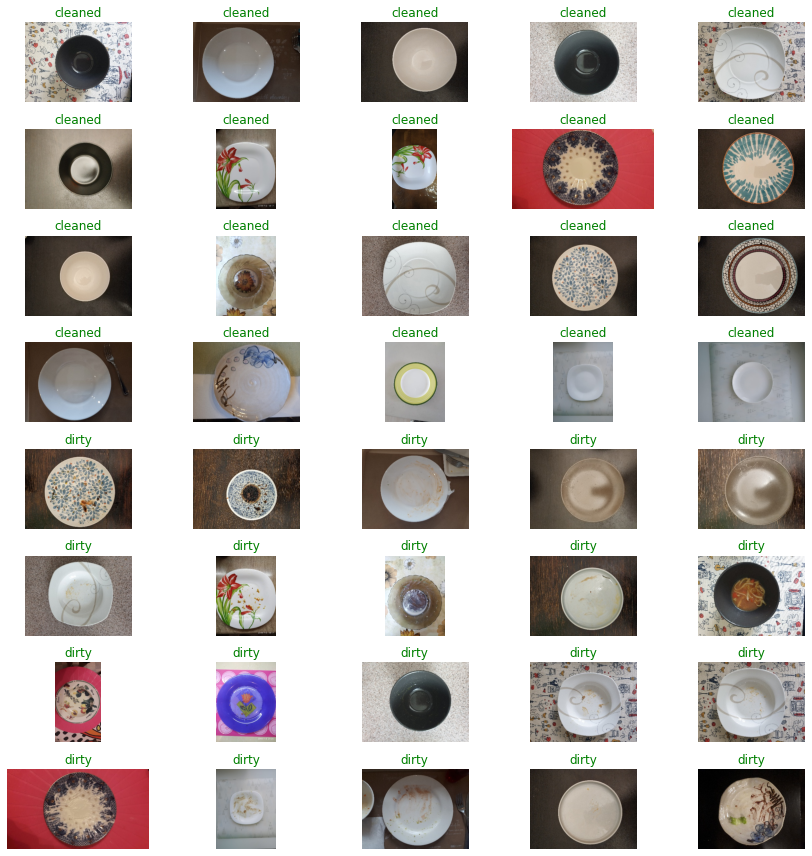

In [ ]:
display_image_grid(correct_images_filepaths)

In [ ]:
def visualize_augmentations(dataset, idx=0, samples=20, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        #image = dataset[idx]['image']
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()    

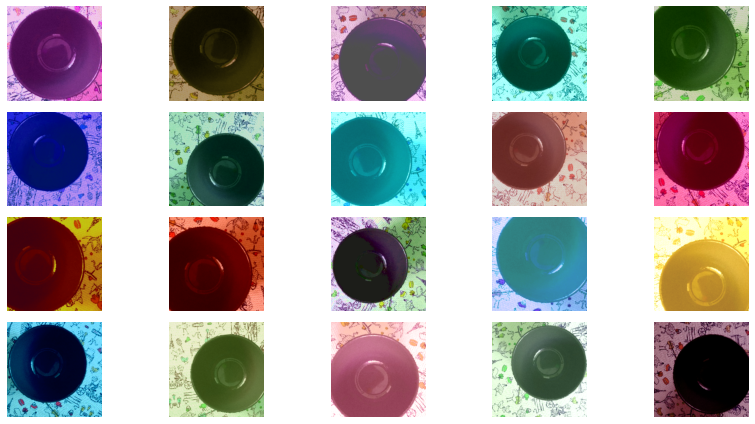

In [ ]:
random.seed(42)
visualize_augmentations(train_dataset)

In [ ]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    train_los=[]
    train_acc=[]
    val_los=[]
    val_acc=[]
    for epoch in tqdm(range(num_epochs)):

        
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader                
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

           
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels=labels.type(torch.LongTensor)
                labels=torch.LongTensor(labels)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()
                        scheduler.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)
            if phase=='train':
              train_los.append(epoch_loss)
              train_acc.append(epoch_acc)
            else:
              val_los.append(epoch_loss)
              val_acc.append(epoch_acc)
              

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model#,train_los,train_acc,val_los,val_acc

In [ ]:
import torch.nn.modules as nn

In [ ]:
torch.cuda.is_available()

True

# Transfer learning

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def get_model():

  #model = models.resnet18(pretrained=True)

  model = models.resnet50(pretrained=True)  

  # Disable grad for all conv layers
  for param in model.parameters():
      param.requires_grad = False

  input_f=model.fc.in_features

  k=1
    
  fc_3x=torch.nn.Sequential(
      
      nn.Linear(input_f,1024*k),
      nn.BatchNorm1d(1024*k),
      nn.ReLU(),

      nn.Linear(1024*k,1024*k),
      nn.BatchNorm1d(1024*k),
      nn.ReLU(),

      nn.Linear(1024*k,1024*k),
      nn.BatchNorm1d(1024*k),
      nn.ReLU(),

      nn.Linear(1024*k,1024*k),
      nn.BatchNorm1d(1024*k),
      nn.ReLU(),

      nn.Linear(1024*k,2)
  )

  #model_rn18.fc = torch.nn.Linear(model_rn18.fc.in_features, 2)
  model.fc = fc_3x

  
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  model = model.to(device)

  loss = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3,weight_decay=1e-4)

  # Decay LR by a factor of 0.1 every 7 epochs
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.7)  

  return model,loss,optimizer,scheduler

In [ ]:
seed()
model,loss,optimizer,scheduler=get_model()
model=train_model(model,loss,optimizer,scheduler, num_epochs=400);

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Epoch 0/399:
train Loss: 0.8305 Acc: 0.4750
val Loss: 0.6537 Acc: 0.5000
Epoch 1/399:
train Loss: 0.9914 Acc: 0.7500
val Loss: 0.5020 Acc: 0.7750
Epoch 2/399:
train Loss: 0.5348 Acc: 0.8500
val Loss: 0.5706 Acc: 0.7250
Epoch 3/399:
train Loss: 0.4066 Acc: 0.8750
val Loss: 0.3688 Acc: 0.8250
Epoch 4/399:
train Loss: 0.1901 Acc: 0.9250
val Loss: 0.3655 Acc: 0.8500
Epoch 5/399:
train Loss: 0.2554 Acc: 0.9000
val Loss: 0.2320 Acc: 0.8750
Epoch 6/399:
train Loss: 0.3056 Acc: 0.8750
val Loss: 0.1526 Acc: 0.9500
Epoch 7/399:
train Loss: 0.3202 Acc: 0.9000
val Loss: 0.1479 Acc: 0.9000
Epoch 8/399:
train Loss: 0.2435 Acc: 0.9000
val Loss: 0.1774 Acc: 0.9000
Epoch 9/399:
train Loss: 0.2242 Acc: 0.9250
val Loss: 0.1543 Acc: 0.9500
Epoch 10/399:
train Loss: 0.2689 Acc: 0.8250
val Loss: 0.2106 Acc: 0.9500
Epoch 11/399:
train Loss: 0.1825 Acc: 0.9500
val Loss: 0.1204 Acc: 0.9500
Epoch 12/399:
train Loss: 0.2617 Acc: 0.8750
val Loss: 0.0813 Acc: 0.9750
Epoch 13/399:
train Loss: 0.2179 Acc: 0.8750
val

In [ ]:
def prediction(model,test_dataloader): 
  test_predictions = []
  test_img_paths = []
  model.eval()
  for inputs, paths in tqdm(test_dataloader):
      inputs = inputs.to(device)      
      with torch.set_grad_enabled(False):
          preds = model(inputs)
      test_predictions.append(
          torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
      test_img_paths.extend(paths)
      
  test_predictions = np.concatenate(test_predictions)
  return test_predictions,test_img_paths

In [ ]:
test_predictions,test_img_paths=prediction(model,test_dataloader)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


# Subm

In [ ]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths,
                                        'label' : test_predictions                                       
                                        })
submission_df.head()

,id,label
0,/content/work/plates/test/0000.jpg,0.000982
1,/content/work/plates/test/0001.jpg,0.094332
2,/content/work/plates/test/0002.jpg,0.037708
3,/content/work/plates/test/0003.jpg,0.001976
4,/content/work/plates/test/0004.jpg,0.030815


In [ ]:
mymodels=['model_A',	'model_B',	'model_C']

In [ ]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'cleaned' if pred > 0.5 else 'dirty')
#submission_df[mymodels] = submission_df[mymodels].applymap(lambda pred: 1 if pred > 0.5 else 0) #1-cleaned 0 - dirty
submission_df.head()



,id,label
0,/content/work/plates/test/0000.jpg,dirty
1,/content/work/plates/test/0001.jpg,dirty
2,/content/work/plates/test/0002.jpg,dirty
3,/content/work/plates/test/0003.jpg,dirty
4,/content/work/plates/test/0004.jpg,dirty


In [ ]:
submission_df['id'] = submission_df['id'].str.replace('/content/work/plates/test/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)


,label
id,
0000,dirty
0001,dirty
0002,dirty
0003,dirty
0004,dirty
0005,dirty


In [ ]:
submission_df=submission_df[['label']]
submission_df.head()

,label
id,
0000,dirty
0001,dirty
0002,dirty
0003,dirty
0004,dirty


In [ ]:
submission_df.to_csv('submission.csv')

In [ ]:
submission_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 744 entries, 0000 to 0743
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   744 non-null    object
dtypes: object(1)
memory usage: 11.6+ KB
